## Homework 3: Machine learning

In this assignment, we'll practice the classification skills from machine learning. We'll use the precinct-level voting data to predict support for Prop 21 (rent control) on the 2020 ballot. For example, we might expect the share of renters to be an important predictor.

We'll also review joins as we prepare the data.

Start by loading the 2020 elections results from LA County into a `pandas` dataframe, `voteDf` (This is exactly the same data as we used in the clustering lectures; I put another copy of the data file in the assignment GitHub folder to make things easier.)

In [1]:
import pandas as pd

voteDf = pd.read_csv('c037_g20_sov_data_by_g20_srprec.csv') # Load the data into a DF

In [2]:
# Autograding tests - do not edit
assert len(voteDf) == 4313
assert isinstance(voteDf, pd.DataFrame)

To do some prediction, we'll want to add variables from (say) the census or other sources.
For that, we need the lookup file that matches precincts to census blocks and tracts. [You can find it here](https://statewidedatabase.org/d10/g20_geo_conv.html), or just use the file `c037_g20_sr_blk_map.csv` in your GitHub repository. (Note that there are several types of precincts; the ones that we are using here are called `srprec`.) 

Each precinct intersects with many census blocks. The `pctsrprec` column tells you how much of the precinct lies within that block. For example, in the first few rows of `c037_g20_sr_blk_map.csv`, you'll see 49 different rows for precint `0050003A`, each matching to a different census block, with the `pctsrprec` column adding up to 100.

Our aim is to create a new dataframe with the vote counts (for all of the propositions and other races) aggregated to census tract. This is a multi-stage process, so let's do this step by step.

In this step, you should:
- load in the lookup data into a new dataframe, `lookupDf`
- join the voting dataframe to the lookup dataframe using `srprec`, to create a new dataframe called `joinDf`. This is a 1:many join, since there are many census blocks per precinct. Do an inner join, as the Null values are not going to be useful to us. (In other words, throw away any lookups that don't match a precinct.)
- make sure that `srprec` is the index

In [3]:
lookupDf = pd.read_csv('c037_g20_sr_blk_map.csv') #Load the Data

lookupDf.set_index('srprec',inplace=True) #Set Index for Join
voteDf.set_index('srprec',inplace=True) #Set Index for Join
joinDf = voteDf.join(lookupDf,how='inner') #Join

In [4]:
print(len(lookupDf))
print(len(joinDf))
assert joinDf.index.name=='srprec'
assert len(lookupDf)==77704
assert len(joinDf)==77703
assert joinDf.county.count()==77703
assert joinDf.TOTREG.sum()==168427815

77704
77703


Now let's calculate vote shares on Prop 21 and in the presidential race for each census tract. 

This is slightly tricky, because your data frame `joinDf` will have multiple rows per tract (because the precinct geography does not match the census geography). For example, the following code shows you which precincts intersect with tract 119342. 

13.65% of the first precinct listed, `9004204A`, is in tract 119342.

In [5]:
joinDf[joinDf.tract==119342][['tract','pctsrprec']].sort_index(ascending=False)

,tract,pctsrprec
srprec,,
9004204A,119342,13.653137
9000576A,119342,22.065955
9000576A,119342,25.412221
9000576A,119342,0.533463


In [6]:
joinDf['pr_21_y_tr'] = joinDf['PR_21_Y'] * joinDf['pctsrprec']/100 #Calculate the percent who voted yes by tract
joinDf['pr_21_n_tr'] = joinDf['PR_21_N'] * joinDf['pctsrprec']/100 #Calculate the percent who voted no by tract
joinDf['pr_dem_01_tr'] = joinDf['PRSDEM01'] * joinDf['pctsrprec']/100 #Calculate the percent who voted for Biden by tract
joinDf['pr_rep_01_tr'] = joinDf['PRSREP01'] * joinDf['pctsrprec']/100 #Calculate the percent who voted for Trump by tract

So to aggregate to tracts, you should:
- for each relevant column, multiply the number of votes by `pctsrprec`, and divide by 100 (because `pctsrprec` is a percentage, not a fraction)
- group by census tract and sum those relevant columns, to create a new dataframe called `tractVotes`. It should have columns `PR_21_N`, `PR_21_Y`, `PRSDEM01`, `PRSREP01`, etc.

This will give us our estimate of votes at the tract level.

*Hint*: You can pass multiple columns to `groupby`. E.g. `df.groupby('groupcol')[['col1','col2','col3']].sum()`

In [7]:
#joinDf['pr_21_y_tr']    
tractVotes = joinDf.groupby('tract')[['pr_21_y_tr','pr_21_n_tr','pr_dem_01_tr','pr_rep_01_tr']].sum() #Group the votes by tract and add a sum so we have teh voting data per tract.
tractVotes.rename(columns={'pr_21_y_tr':'PR_21_Y','pr_21_n_tr':'PR_21_N','pr_dem_01_tr':'PRSDEM01','pr_rep_01_tr':'PRSREP01'},inplace=True) #rename the columns 



In [8]:
print(len(tractVotes))
print(tractVotes.PR_21_Y.sum())

# Autograding tests - do not edit
assert len(tractVotes)==2338
assert tractVotes.PR_21_Y.sum().round() == 2021487

2338
2021486.9997128805


Now let's get a dataframe of some relevant census variables, using `cenpy`. Check back to the Week 1 example and the first homework.

Create a dataframe, `censusDf`, with ACS 2019 tract-level data for LA County, and variables for Tenure (B25003_001E, B25003_002E, B25003_003E) and median household income (B19013_001E). Add a column with the percent of renters, called `pct_renter`.

You can also rename the median HH income column to something more meaningful.

*Hint:* Use the `from_county()` function in `cenpy`, which accepts a list of variables. You can see the definitions of these variables with 

```
acs = cenpy.products.ACS()
acs.filter_variables(variable_name)
```

In [9]:
import cenpy
from cenpy import products

acs = cenpy.products.ACS()

censusDf = products.ACS(2019).from_county(county='Los Angeles, CA',level='tract',variables =['B25003_001E','B25003_002E','B25003_003E','B19013_001E']) #pull the relevant variables
censusDf['pct_renter'] = (censusDf['B25003_003E']/censusDf['B25003_001E']) * 100  # calculate the percent of the tract that is renter.




C:\Users\Aaron\anaconda3\envs\environment_2\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\Aaron\anaconda3\envs\environment_2\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Aaron\anaconda3\envs\environment_2\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get

In [10]:
print (len(censusDf))
print (censusDf.pct_renter.mean().round())

# Autograding tests - do not edit
assert len(censusDf) == 2346
assert censusDf.pct_renter.mean().round() == 53

2346
53.0


Create a new dataframe, `joinedDf`, with both your voting and census data, through a left join to the voting data. 

*Hint*: It will be easiest to join on the `tract` column (which is your index in `tractVotes`). Since everything is in LA County, you don't need to worry about the `state` or `county` fields.

*Hint*: You'll need to convert the `tract` column in `censusDf` to an integer first.

In [28]:
censusDf.reset_index(inplace=True) #reset index so join works
tractVotes.reset_index(inplace=True) #reset index so join works

censusDf.tract = censusDf.tract.astype('int') #convert to int type

joinedDf = tractVotes.merge(censusDf,how='left',on='tract') #join the dataframes together

In [29]:
print(joinedDf.pct_renter.count())
print(joinedDf.pct_renter.mean())

# Autograding tests - do not edit
assert joinedDf.pct_renter.count() == 2318
assert joinedDf.pct_renter.mean().round() == 53

2318
53.28817335153003


Let's start with a simple random forests model with the following *x* variables:

* Median HH income
* Percent of HHs that are renters
* Presidential vote (2-party share of Democrat voters, i.e. the percent voting for Biden vs Trump, with other candidates ignored)

And the following *y* variable
* Whether Prop 21 won (received a majority) in that census tract. This should be `True` if the Yeses got more votes than the Nos.

(Yes, vote share in each tract would be better to predict rather than a binary variable - hold off on that for the challenge problem.)

Create the relevant columns, `pct_biden` and `PR_21_won`, in your `joinedDf` dataframe. 

Then split your dataframe into a training sample (75%) and a test sample (25%). *Hint*: Drop the `NaNs` first.

In [19]:
# your code here
#X_train, X_test, y_train, y_test = 999, 999, 999, 999

joinedDf['PR_21_won'] = joinedDf['PR_21_Y']/(joinedDf['PR_21_Y']+joinedDf['PR_21_N']) # % Who voted yes on Prop 21
joinedDf['pct_biden'] =  joinedDf['PRSDEM01']/(joinedDf['PRSDEM01']+joinedDf['PRSREP01']) #% of Biden Voters


In [20]:
joinedDf['PR_21_won']=joinedDf['PR_21_won']>0.5   #Set if true if Prop 21 won.


In [22]:
from sklearn.model_selection import train_test_split
xvars = ['pct_biden','B19013_001E','pct_renter'] #X variables
yvar = 'PR_21_won'#outcome variable

df_to_fit = joinedDf[xvars+[yvar]].dropna() #drop NAs
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)  #set up the train/test split.

In [23]:
print(len(X_train))
print(len(X_test))
print(X_train.pct_biden.mean())
print(y_train.mean())

# Autograding tests - do not edit
assert len(X_train) == 1731
assert len(X_train.columns) == 3
assert len(X_test) == 578
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert X_train.pct_biden.mean().round() == 74
assert y_train.mean().round(2) == 0.60



1731
578
0.7399448083312072
0.5979202772963604


AssertionError: 

Estimate a random forests model, and assign the predicted *y* values from your *test* sample to `y_pred`.

In [24]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 50, random_state = 1) #set up random forest

# now fit the model
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test) #run random forest
y_pred

array([False,  True,  True, False, False, False, False,  True,  True,
        True,  True, False,  True, False,  True,  True, False, False,
        True, False,  True, False,  True, False,  True,  True, False,
        True, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
        True,  True, False,  True,  True, False, False, False,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,  True, False,  True, False, False, False, False,
       False,  True,  True, False, False, False,  True,  True, False,
        True,  True,

In [25]:
print(len(y_pred))
print(y_pred.mean())

# Autograding tests - do not edit
assert len(y_pred)==len(y_test)
assert y_pred.mean().round(1) == 0.6

578
0.6314878892733564


Let's look at some measures of fit. Plot the confusion matrix.

[[192  31]
 [ 21 334]]


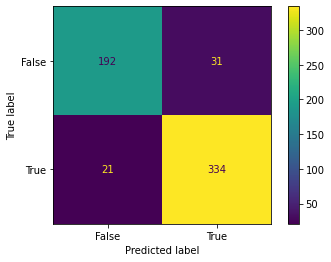

In [26]:
# your code here
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred) #plot confusion matrix

Finally, plot the importance of each of the 3 predictor variables, in the same way as we did in class.

Text(0, 0.5, 'Mean decrease in impurity')

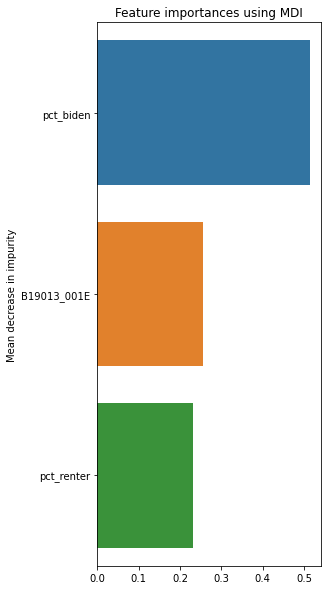

In [27]:
# your code here
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)
# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(4,10))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Comment briefly on your interpretation of the results - your predictive power, which variables are important, and how you might refine the model.

Overall, the predictive power of the model was good, with a 57.8% accuracy. The number of Biden voters is by far the biggest predictor in this model, and median income/percent renter of the tracts was roughly equivalent in terms of importance (~25%).  To refine the model, I would include other variables commonly associated with progressive voting: level of education and population density. Including racial demographics, standardized to % non-white may also increase the power of the model.


# Challenge Problem
Remember, you need to do at least two of these challenge problems this quarter.

This challenge problem is open ended for you to take in a direction that you are most interested in. Here are some suggestions (do 1 or 2 of these):

* Extend the random forests model to predict vote share on Prop 21, rather than a binary yes/no, and using additional variables. See suggestions below. 
* Use a neural network instead. How much does this improve the predictions? Use charts to compare the predictions to the random forests model.
* Examine the geographic distribution of the predictions, through mapping the prediction errors. Where does your model perform best? Does this give you pointers as to how to improve your model?

In all cases, write some brief interpretation in a markdown cell.

*Predicting a continuous variable*

Classification problems are typically binary or categorical - which category do you predict a given observation to fall into. In some cases, however, we might want to predict a continuous variable, such as the percentage of "yes" votes on Prop 21. For this we can use `RandomForestRegressor`, which works very similarly to `RandomForestClassifier`. You can follow exactly the same steps: create the `rf` object, fit the model, and predict using the test sample.

How do you evaluate model performance? Since we have a continuous variable, we can't use the confusion matrix. But we can look at the absolute error (each predicted value minus the true value for each of our test precincts). I.e., `abs(y_pred-y_test)`. You can also do a scatter plot of the predicted values against the true values. The divergence from the 45 degree line is a good indication of how well the model fits.